Goal: combine SNAP data, which is monthly trends over 100 years, and DayMet, which is daily data over recent history, to form a reasonable cycle of data following the SNAP trend but with reasonable daily cycles.

In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
#import colors
import itertools

In [2]:
# short names for keys
k_T = 'air temperature [K]'
k_qSW = 'incoming shortwave radiation [W m^-2]'
k_qLW = 'incoming longwave radiation [W m^-2]'
k_Pr = 'precipitation rain [m s^-1]'
k_Ps = 'precipitation snow [m SWE s^-1]'
k_P = 'precipitation [m s^-1]'
k_RH = 'relative humidity [-]'
k_time = 'time [s]'
k_U = 'wind speed [m s^-1]'


In [3]:
def load_met(fname, adjust=-1,cycle=365):
    daymet = dict()
    with h5py.File(fname,'r') as _daymet:
        keys = _daymet.keys()
        assert(len(_daymet[k_time][:])%cycle == 0)
        daymet_nyears = int(len(_daymet[k_time][:]) / cycle)

        for k in keys:
            if k != k_time:
                daymet[k] = _daymet[k][:].reshape((daymet_nyears,cycle))
    try:
        daymet[k_P] = daymet[k_Pr] + daymet[k_Ps]
        if (adjust>1):
            daymet[k_P] = adjust*daymet[k_P]
    except KeyError:
        pass
    return daymet_nyears, daymet
  
def load_barrow_observed_met(fname, cycle=365):
    daymet = dict()
    with h5py.File(fname,'r') as _daymet:
        keys = _daymet.keys()
        end = 0
        if (len(_daymet[k_time][:])%cycle == 0):
            end = -1
        else:
            end = -(len(_daymet[k_time][:])%cycle)
        print (len(_daymet[k_time][:]),end)
        daymet_nyears = int(len(_daymet[k_time][:end]) / cycle)

        for k in keys:
            if k != k_time:
                daymet[k] = _daymet[k][:end].reshape((daymet_nyears,cycle))
    try:
        daymet[k_P] = daymet[k_Pr] + daymet[k_Ps]
    except KeyError:
        pass
    return daymet_nyears, daymet

In [4]:
nyears, daymet = load_met('../Barrow_Alaska/barrow1985-2015-trend-smooth.h5',adjust=1.3)
year_dm = np.arange(1985, 1985+nyears)
normalization = dict()

nyears_bo, barrow_observed = load_barrow_observed_met('../Barrow_Alaska/Barrow-2010_2016-updated-smooth-30pc.h5')
year_bo = np.arange(2010, 2010+nyears_bo)

2513 -323


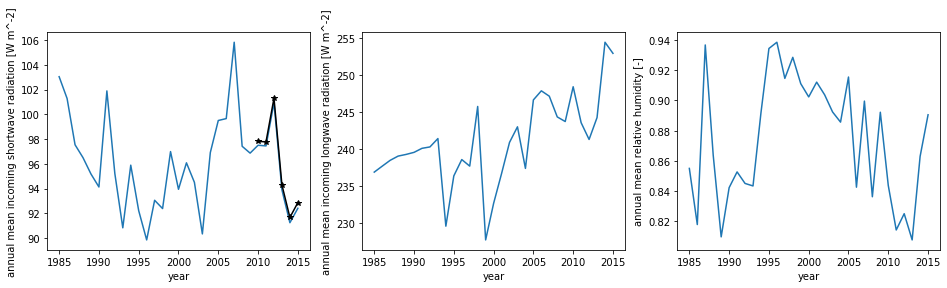

In [5]:
# check for trends in things we don't expect trends in
plt.figure(figsize=(16,4))

for i,k in enumerate([k_qSW, k_qLW, k_RH]):
    means = daymet[k].mean(1)
    plt.subplot(1,3,i+1)
    plt.plot(year_dm,means)
    plt.ylabel('annual mean %s'%k)
    plt.xlabel('year')
    if i == 0:
        means_bo = barrow_observed[k_qSW].mean(1)
        plt.plot(year_bo,means_bo, 'k-*', label='BO data annual mean')


plt.show()

# they look good now that wind speed has been detrended!  Look safe to use to me.
normalization[k_qSW] = daymet[k_qSW] / daymet[k_qSW].mean()
normalization[k_RH] = daymet[k_RH] - daymet[k_RH].mean()
normalization[k_qLW] = daymet[k_qLW] / daymet[k_qLW].mean()

6.421879381879041e-09 7.719321862066067e-09


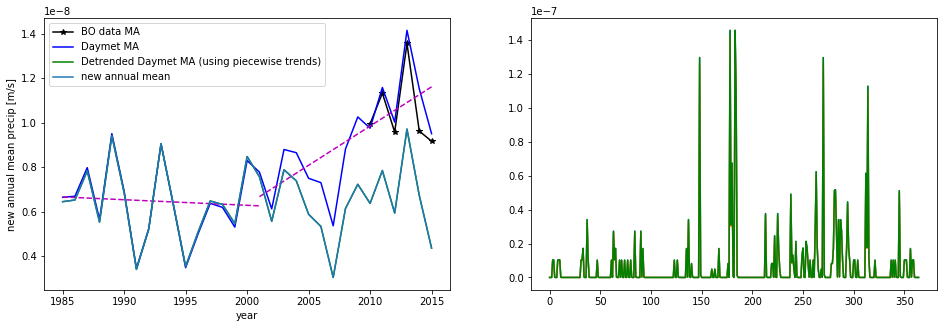

In [6]:
#%matplotlib qt
# do we need to detrend precip?

#Plot Observed Barrow Data 
means_bo = barrow_observed[k_P].mean(1)
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(year_bo,means_bo, 'k-*', label='BO data MA')
plt.ylabel('annual mean precip [m/s]')
plt.xlabel('year')


means = daymet[k_P].mean(1)
#plt.plot(daymet[k_P][10])#, label='RRraw data annual mean')

#plt.plot(year_dm,means, label='raw data annual mean',color='r')
plt.plot(year_dm,means, label='Daymet MA',color='b')
plt.ylabel('annual mean precip [m/s]')
plt.xlabel('year')

# detrend the first 17 years?
polyfit = np.poly1d(np.polyfit(np.arange(0,17), means[0:17], deg=1))
plt.plot(year_dm[:17], polyfit(np.arange(0,17)),linestyle='dashed',color='m')

# detrend the last 15 years?
polyfit2 = np.poly1d(np.polyfit(np.arange(nyears-15, nyears), means[-15:], deg=1))
plt.plot(year_dm[16:], polyfit2(np.arange(nyears-15,nyears)),linestyle='dashed',color='m')

# shift the means
center = (polyfit(16) + polyfit2(nyears-15))/2.
mean_shift = np.zeros((nyears,),'d')
mean_shift[0:17] = polyfit(np.arange(0,17)) - center
mean_shift[-15:] = polyfit2(np.arange(nyears-15,nyears)) - center
#print(mean_shift)
plt.plot(year_dm, means - mean_shift, label='Detrended Daymet MA (using piecewise trends)',color='g')

# transform precip by scaling -- this is necessary to keep positive
# effectively this means that all changes in precip will be changes in precip intensity.  
# This is equivalent to duration over a day, i.e. we see no difference between raining
# twice as hard and raining twice as long over a given day.  But it doesn't introduce 
# more events or make it rain on days it doesn't currently rain on.
transform = (means - mean_shift) / means
#print('Transform: ',transform)
precip = np.array([daymet[k_P][i,:]*(means[i] - mean_shift[i])/means[i] for i in range(nyears)])
new_means = precip.mean(1)

precip_aj = np.array([daymet[k_P][i,:] for i in range(nyears)])
new_means_aj = precip_aj.mean(1)
print (np.mean(new_means), np.mean(new_means_aj))
"""
# AJK
# detrend entire dataset?
polyfit = np.poly1d(np.polyfit(np.arange(0,nyears), means, deg=1))
plt.plot(year_dm, polyfit(np.arange(0,nyears)),color='c',linestyle='dashed')
center = polyfit(nyears/2)
mean_shift = np.zeros((nyears,),'d')
mean_shift = polyfit(np.arange(0,nyears)) - center
print ('H:', mean_shift, center)
plt.plot(year_dm, means - mean_shift, label='Detrended Daymet MA (using linear trend)',color='r')
"""


plt.plot(year_dm,new_means, label='new annual mean')
plt.ylabel('new annual mean precip [m/s]')
plt.xlabel('year')
plt.legend()

plt.subplot(122)
plt.plot(daymet[k_P][0,:])
plt.plot(precip[0])
plt.plot(precip_aj[0],'g')
#print(daymet[k_P][0,:].mean(), precip[0].mean())

plt.show()
for i in range(len(precip)):
    for p1, p2 in zip(precip_aj[i], precip[i]):
        if (p1 <0 or p2 <0):
            print (p1, p2)
            break
# normalize to 1, then save
normalization[k_P] = precip / precip.mean()

[-1.5502119  -1.45888776 -1.36756362 -1.27623947 -1.18491533 -1.09359119
 -1.00226704 -0.9109429  -0.81961876 -0.72829461 -0.63697047 -0.54564633
 -0.45432218 -0.36299804 -0.2716739  -0.18034975  0.08902561  0.18776939
  0.28651316  0.38525694  0.48400072  0.58274449  0.68148827  0.78023205
  0.87897583  0.9777196   1.07646338  1.17520716  1.27395094  1.37269471
  1.47143849]
262.897994167288 262.9340723915056


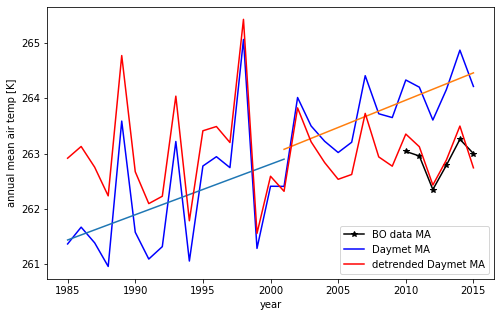

In [7]:
#Plot Observed Barrow Data 
means_bo = barrow_observed[k_T].mean(1)
plt.figure(figsize=(8,5))
plt.plot(year_bo,means_bo, 'k-*', label='BO data MA')
plt.ylabel('annual mean air temp [K]')
plt.xlabel('year')

# do we need to detrend air temp?
means = daymet[k_T].mean(1)
#plt.figure()
plt.plot(year_dm,means, label='Daymet MA',color='b')
plt.ylabel('annual mean air temp [K]')
plt.xlabel('year')

# again, do with a split at the 17th year...
# detrend the first 17 years?
polyfit = np.poly1d(np.polyfit(np.arange(0,17), means[0:17], deg=1))
plt.plot(year_dm[:17], polyfit(np.arange(0,17)))

# detrend the last 15 years?
polyfit2 = np.poly1d(np.polyfit(np.arange(nyears-15, nyears), means[-15:], deg=1))
plt.plot(year_dm[16:], polyfit2(np.arange(nyears-15,nyears)))

# shift the means
center = (polyfit(16) + polyfit2(nyears-15))/2.
mean_shift = np.zeros((nyears,),'d')
mean_shift[0:17] = polyfit(np.arange(0,17)) - center
mean_shift[-15:] = polyfit2(np.arange(nyears-15,nyears)) - center
print(mean_shift)
plt.plot(year_dm,means - mean_shift, label='detrended Daymet MA',color='r')
plt.legend()
print (np.mean(means_bo),np.mean(means) )
plt.show()

[-1.55232995e+00 -1.44884129e+00 -1.34535262e+00 -1.24186396e+00
 -1.13837530e+00 -1.03488663e+00 -9.31397970e-01 -8.27909307e-01
 -7.24420644e-01 -6.20931980e-01 -5.17443317e-01 -4.13954653e-01
 -3.10465990e-01 -2.06977327e-01 -1.03488663e-01 -5.68434189e-14
  1.03488663e-01  2.06977327e-01  3.10465990e-01  4.13954653e-01
  5.17443317e-01  6.20931980e-01  7.24420644e-01  8.27909307e-01
  9.31397970e-01  1.03488663e+00  1.13837530e+00  1.24186396e+00
  1.34535262e+00  1.44884129e+00  1.55232995e+00]


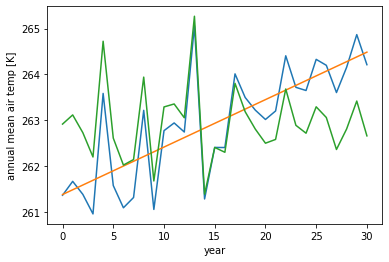

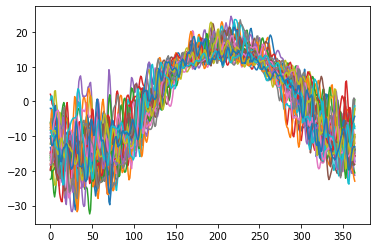

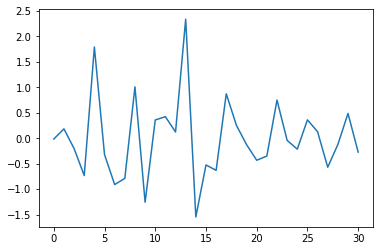

In [8]:
# actually that's just a flat line...
plt.figure()
plt.plot(means, label='raw data annual mean')
plt.ylabel('annual mean air temp [K]')
plt.xlabel('year')

polyfit = np.poly1d(np.polyfit(np.arange(0,nyears), means, deg=1))
plt.plot(np.arange(0,nyears), polyfit(np.arange(0,nyears)))

# shift the means
mean_shift = polyfit(np.arange(0,nyears)) - means.mean()
print(mean_shift)
plt.plot(means - mean_shift, label='detrended target annual mean')

# shift the data
air_temp = np.array([daymet[k_T][i,:] - mean_shift[i] for i in range(nyears)])

# save normalization as zero-mean
normalization[k_T] = air_temp - air_temp.mean()

plt.figure()
for ta in normalization[k_T]:
    plt.plot(ta)

plt.figure()
plt.plot(normalization[k_T].mean(1))

plt.show()

In [9]:
# load the SNAP data
nyears_s, snap = load_met("snap-2006-2100-monthly.h5", cycle=12)
year_s = np.arange(2006, 2006+nyears_s)


In [10]:
# also load CESM RCP4.5 just for comparison sake
nyears_c, cesm45 = load_met("../CESM/CESM_4_5.h5", cycle=365)
year_c = np.arange(2006, 2006+nyears_c)

nyears_c85, cesm85 = load_met("../CESM/CESM_8_5.h5", cycle=365)


In [11]:
#cm = colors.cm_mapper(0,3)
cm = ['b','k','r','g','c','p']
def plot(yr, ds, k, label, i,scale=1):
    #print (scale)
    plt.plot(yr, ds[k].mean(1)*scale, label=label, color=cm[i])
    poly = np.poly1d(np.polyfit(yr, ds[k].mean(1)*scale, deg=1))
    plt.plot(yr, poly(yr), color=cm[i])
    return poly

poly_trends = dict()
for dset in ['DayMet', 'SNAP', 'CESM RCP4.5', 'CESM RCP8.5']:
    poly_trends[dset] = dict()
    
def plot_all(k):
    poly_trends['DayMet'][k] = plot(year_dm, daymet, k, 'DayMet', 0)
    #poly_trends['SNAP'][k] = plot(year_s, snap, k, 'SNAP', 1)
    #poly_trends['CESM RCP4.5'][k] = plot(year_c, cesm45, k, 'CESM RCP4.5', 2)
    scale = 1
    if 'air temp' in k:
        scale = 1.0035
    elif 'precipitation [m s^-1]' in k:
        scale = 1.5
    poly_trends['CESM RCP8.5'][k] = plot(year_c, cesm85, k, 'CESM RCP8.5', 3,scale=scale)
    #plt.plot(year_bo,means_bo, 'r-*', label='BO data annual mean')
    plt.xlabel('year')
    plt.ylabel("annual mean %s"%k)
    plt.legend()



/Users/ajc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


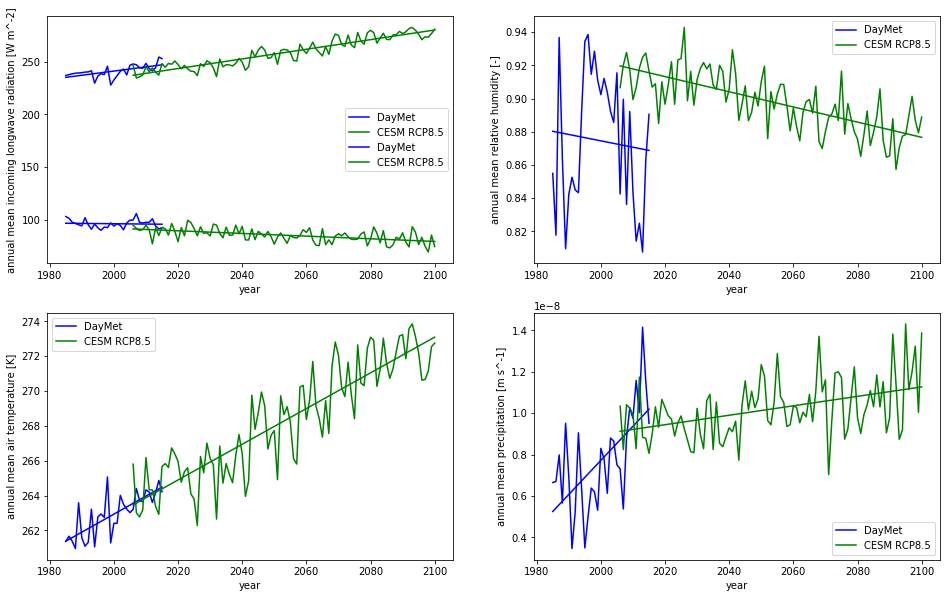

In [12]:
# check for trends
plt.figure(figsize=(16,10))
plt.subplot(221)
plot_all(k_qSW)
plt.subplot(221)
plot_all(k_qLW)
plt.subplot(222)
plot_all(k_RH)
plt.subplot(223)
plot_all(k_T)
plt.subplot(224)
plot_all(k_P)


In [13]:
# utilities
def year_generator(dat):
    print ('Shape: ',dat.shape[0])
    for i in itertools.cycle(range(dat.shape[0])):
        #print (i,len(dat[i,:]))
        yield dat[i,:]
       
    
def plot(years, precip_proj, trend_poly, k):
    plt.figure(figsize=(16,7))
    plt.plot(np.arange(years[0], years[-1]+1, 1.0/365), precip_proj.ravel())
    plt.plot(np.arange(year_dm[0], year_dm[-1]+1, 1.0/365), daymet[k].ravel())

    plt.plot(year_dm, poly_trends['DayMet'][k](year_dm))
    plt.plot(year_dm, daymet[k].mean(1))
    plt.plot(years, trend_poly(years))
    plt.plot(years, precip_proj.mean(1))
    plt.xlabel('year')
    plt.ylabel(k)
    plt.show()   

def get_normalized(norm):
    xd = np.concatenate(norm)
    xd = np.concatenate((xd[365*21:], xd[:365*21]))
    xd = np.reshape(xd,(-1,365))
    return xd

def project_and_plot(years, trend_poly, normalized_o, k, operator='additive'):
    print (years[:4])
    normalized = get_normalized(normalized_o)
    print("Projecting: %s"%k)
    if operator == 'additive':
        precip_proj = np.array([pr + trend_poly(yr) for yr, pr in zip(years, year_generator(normalized))])
    elif operator == 'multiplicative':
        precip_proj = np.array([pr*trend_poly(yr) for yr, pr in zip(years, year_generator(normalized))])
    else:
        raise RuntimeError('invalid operator, must be "additive" or "multiplicative"')
    print(precip_proj.shape)
    plot(years, precip_proj, trend_poly, k)
    
    # check min/max are reasonable
    print(precip_proj.min(), precip_proj.max())
    return precip_proj  


In [14]:
# projected dataset
proj = dict()


In [15]:
# use snap precip
#proj[k_P] = project_and_plot(year_s, poly_trends['SNAP'][k_P], normalization[k_P], k_P, operator="multiplicative")

[2006 2007 2008 2009]
Projecting: air temperature [K]
Shape:  31
(95, 365)


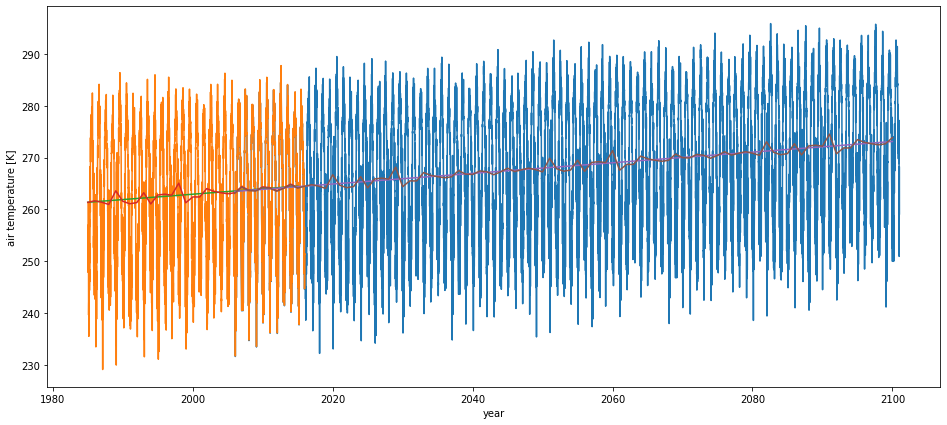

231.68259333027098 295.79586668256866
[2006 2007 2008 2009]
Projecting: relative humidity [-]
Shape:  31
(95, 365)


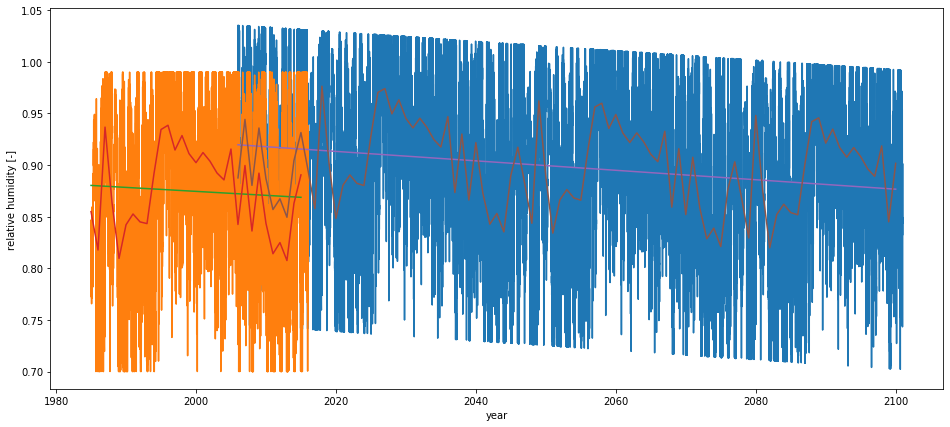

0.702120383617496 1.0351261701133763
[2006 2007 2008 2009]
Projecting: incoming shortwave radiation [W m^-2]
Shape:  31
(95, 365)


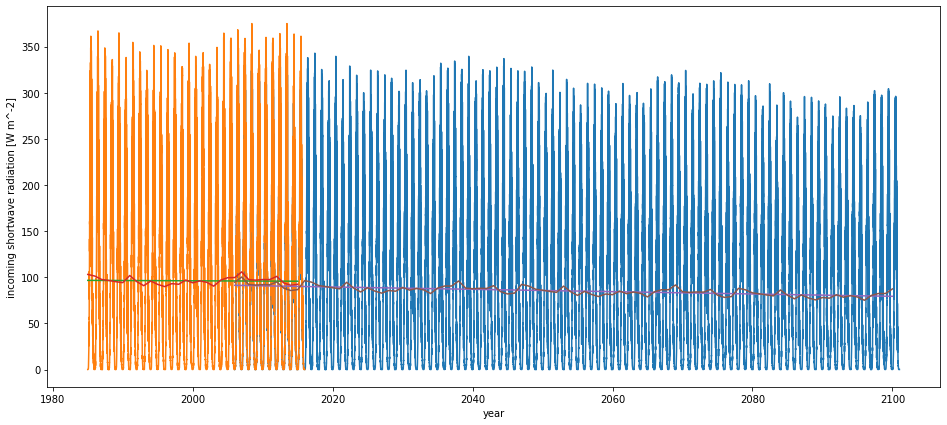

0.0 354.71511261221855
[2006 2007 2008 2009]
Projecting: incoming longwave radiation [W m^-2]
Shape:  31
(95, 365)


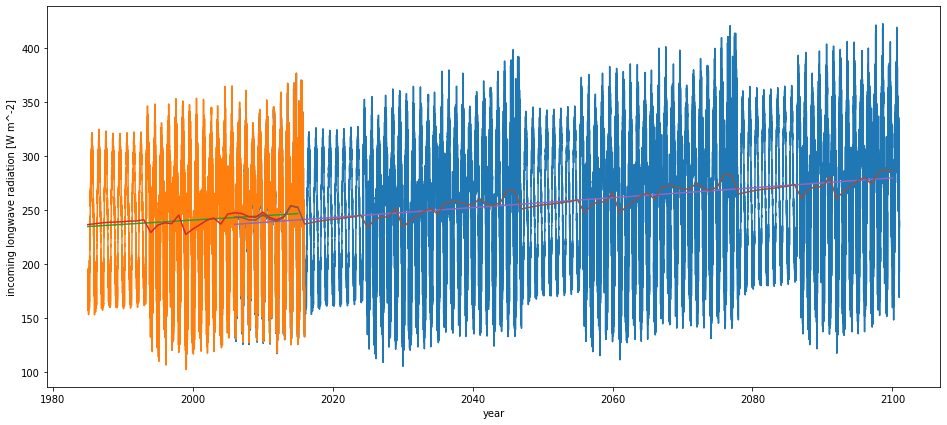

105.72892591465207 423.01118734172417
[2006 2007 2008 2009]
Projecting: precipitation [m s^-1]
Shape:  31
(95, 365)


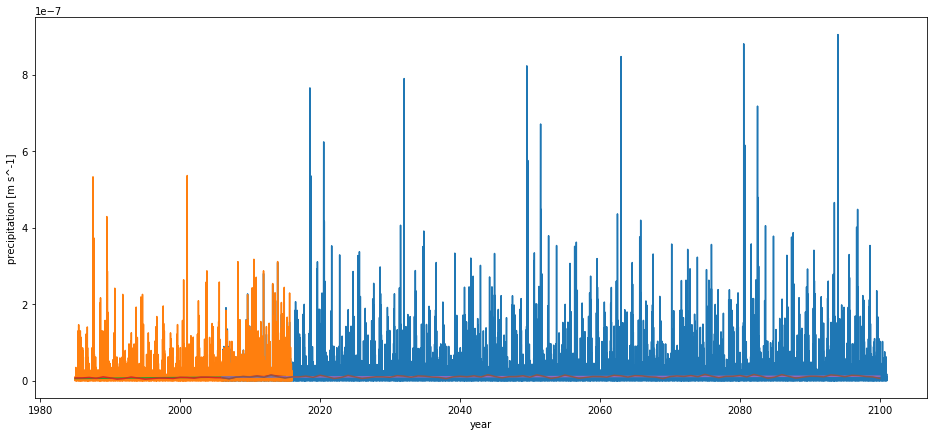

0.0 9.043902739082846e-07


In [16]:
#%matplotlib qt
# use CESM RCP8.5 air temperatures, RH, and incoming SW
proj[k_T] = project_and_plot(year_c, poly_trends['CESM RCP8.5'][k_T], normalization[k_T], k_T, operator='additive')
proj[k_RH] = project_and_plot(year_c, poly_trends['CESM RCP8.5'][k_RH], normalization[k_RH], k_RH, operator='additive')
proj[k_qSW] = project_and_plot(year_c, poly_trends['CESM RCP8.5'][k_qSW], normalization[k_qSW], k_qSW, operator='multiplicative')
proj[k_qLW] = project_and_plot(year_c, poly_trends['CESM RCP8.5'][k_qLW], normalization[k_qLW], k_qLW, operator='multiplicative')

proj[k_P] = project_and_plot(year_c, poly_trends['CESM RCP8.5'][k_P], normalization[k_P], k_P, operator='multiplicative')


# uh oh, need to filter RH

In [ ]:
def filter(dat, min_val, max_val, policy='avg'):
    if policy == 'clip':
        dat = np.where(dat > max_val, max_val, dat)
        dat = np.where(dat < min_val, min_val, dat)
        return dat
    elif policy == 'avg':
        bad_high = np.where(dat > max_val)[0]
        for bh in bad_high:
            bh_l = bh - 1
            while bh_l in bad_high:
                bh_l -= 1
                
            bh_u = bh + 1
            while bh_u in bad_high:
                bh_u += 1
            
            if bh_l < 0:
                dat[bh] = dat[bh_u]
            elif bh_u >= len(dat):
                dat[bh] = dat[bh_l]
            else:
                dat[bh] = (dat[bh_u] + dat[bh_l]) / 2.

        bad_low = np.where(dat < min_val)[0]
        for bh in bad_low:
            bh_l = bh - 1
            while bh_l in bad_low:
                bh_l -= 1
                
            bh_u = bh + 1
            while bh_u in bad_low:
                bh_u += 1
            
            if bh_l < 0:
                dat[bh] = dat[bh_u]
            elif bh_u >= len(dat):
                dat[bh] = dat[bh_l]
            else:
                dat[bh] = (dat[bh_u] + dat[bh_l]) / 2. 
        return dat
    else:
        raise RuntimeError('Policy must be "avg" or "clip"')



In [ ]:
# filter RH
shp = proj[k_RH].shape
proj[k_RH] = filter(proj[k_RH].ravel(), 0.5, 0.99, 'avg').reshape(shp)

plot(year_c, proj[k_RH], poly_trends['CESM RCP8.5'][k_RH], k_RH)


In [ ]:
# just cycle wind speed
proj[k_U] = np.array([d for i,d in zip(range(len(year_c)), year_generator(daymet[k_U]))])
plt.figure(figsize=(16,7))
plt.plot(np.arange(year_c[0], year_c[-1]+1, 1.0/365), proj[k_U].ravel())

print(daymet[k_U].min(), daymet[k_U].max())
print(proj[k_U].min(), proj[k_U].max())

In [ ]:
# partition rain
#precip = proj.pop(k_P)

#proj[k_Ps] = np.where(proj[k_T] > 273.15, 0., precip)
#proj[k_Pr] = np.where(proj[k_T] > 273.15, precip, 0)

proj[k_Ps] = np.where(proj[k_T] >= 273.15, 0., proj[k_P])
proj[k_Pr] = np.where(proj[k_T] > 273.15, proj[k_P], 0)

plt.figure(figsize=(16,7))
plt.plot(np.arange(year_c[0], year_c[-1]+1, 1.0/365), proj[k_Ps].ravel(), 'c')
plt.plot(np.arange(year_c[0], year_c[-1]+1, 1.0/365), proj[k_Pr].ravel(), 'b')
plt.show()



In [ ]:
# save to file
times = np.arange(86400./2, len(year_c) * 365 * 86400 +1, 86400)
assert(len(times) == 365*95)

with h5py.File("CESM-RCP8.5-2006-2100_dm1985-2015-ET.h5",'w') as fout:
    fout.create_dataset(k_time, data=times)
    for k in proj.keys():
        fout.create_dataset(k, data=proj[k].ravel())

    

In [ ]:
#Read and check Data
data_et = h5py.File("CESM-RCP8.5-2006-2100_dm1985-2015-ET.h5",'r')
print (data_et.keys())
precip = data_et['precipitation [m s^-1]']
precip_annual = np.reshape(precip,(-1,365)).mean(axis=1)*1000*86400*365
print (precip_annual.shape)
poly = np.polyfit(np.arange(2005,2100,1),precip_annual,deg=1)
p = np.poly1d(poly)
plt.plot(np.arange(2006,2016,1),p(np.arange(2006,2016,1)),'r')
plt.plot(np.arange(2006,2016,1),precip_annual[:10],'k-*')


#dm_precip = 2*daymet['precipitation rain [m s^-1]']
#dm_precip_annual = np.reshape(dm_precip,(-1,365)).mean(axis=1)*1000*365*86400
#print (dm_precip_annual.shape,nyears)
#plt.plot(year_dm,dm_precip_annual,'k')


dm_precip = barrow_observed['precipitation rain [m s^-1]'] + barrow_observed['precipitation snow [m SWE s^-1]']
dm_precip_annual = np.reshape(dm_precip,(-1,365)).mean(axis=1)*1000*365*86400
print (dm_precip_annual.shape,nyears)
plt.plot(year_bo,dm_precip_annual,'g')
"""
#Read and check Data
data_et = h5py.File("CESM-RCP8.5-2006-2100_dm1985-2015-FM_2006.h5",'r')
print (data_et.keys())
precip = data_et['precipitation [m s^-1]']
precip_annual = np.reshape(precip,(-1,365)).mean(axis=1)*1000*86400*365
print (precip_annual.shape)
poly = np.polyfit(np.arange(2005,2100,1),precip_annual,deg=1)
p = np.poly1d(poly)
plt.plot(np.arange(2005,2100,1),p(np.arange(2005,2100,1)),'k')
plt.plot(np.arange(2005,2100,1),precip_annual)
"""

In [ ]:
# Same forcing file, 100 year projection, but time starts from 2006
x = 6.622128E8 - 43200
times = np.arange(86400./2, len(year_c) * 365 * 86400 +1, 86400)
times = [x +t for t in times]
print (len(times))
assert(len(times) == 365*95)

#Used smooth historical data
with h5py.File("CESM-RCP8.5-2006-2100_dm1985-2015-ET_2006.h5",'w') as fout:
    fout.create_dataset(k_time, data=times)
    for k in proj.keys():
        print (k)
        fout.create_dataset(k, data=proj[k].ravel())